In [4]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import glob
from skimage import io
import os
import numpy as np
from typing import List, Tuple, Dict
import time
import itertools
from collections import ChainMap
import matplotlib.pyplot as plt

In [14]:
data_dir = "/n/data2/hms/dbmi/kyu/lab/maf4031/incoherent_RGBchannels/test_images_binned_sameProtocol"
imgs = glob.glob(os.path.join(data_dir,'*/*.jpg'))

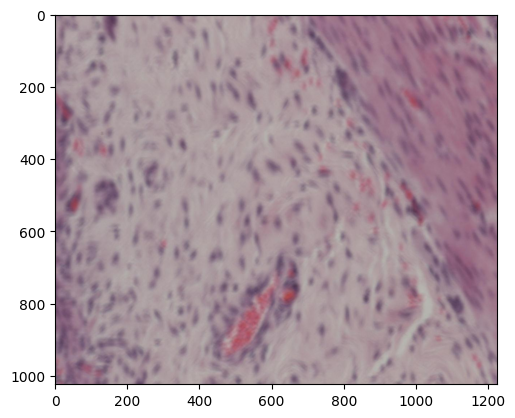

In [15]:
plt.imshow(io.imread(imgs[0]))
plt.show()

In [8]:
import numpy as np
from PIL import Image

def bin_image(image, bin_ratio):
    # Convert the input image to a numpy array
    img_arr = np.array(image)

    # Calculate the new dimensions of the binned image
    new_width = img_arr.shape[1] // bin_ratio
    new_height = img_arr.shape[0] // bin_ratio

    # Create a new numpy array for the binned image
    binned_arr = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    # Loop through the pixels of the binned image and average the color values of the corresponding pixels in the original image
    for y in range(new_height):
        for x in range(new_width):
            # Calculate the indices of the pixels in the original image that correspond to this binned pixel
            y_start = y * bin_ratio
            y_end = (y + 1) * bin_ratio
            x_start = x * bin_ratio
            x_end = (x + 1) * bin_ratio

            # Average the color values of the corresponding pixels in the original image
            color_sum = np.sum(img_arr[y_start:y_end, x_start:x_end], axis=(0, 1))
            color_avg = color_sum // (bin_ratio ** 2)

            # Set the color values of the binned pixel in the new array
            binned_arr[y, x] = color_avg

    # Convert the binned numpy array back to an image
    binned_img = Image.fromarray(binned_arr)

    return binned_img

In [12]:
import numpy as np
from PIL import Image

def bin_image(image, bin_ratio):
    # Convert the input image to a numpy array
    img_arr = np.array(image)

    # Scale the color range of the input array to 0-255
    img_arr_scaled = img_arr.astype(np.float32) / 255.0

    # Calculate the new dimensions of the binned image
    new_shape = (img_arr.shape[0] // bin_ratio, img_arr.shape[1] // bin_ratio, 3)

    # Reshape the input image to a new shape that makes binning easier
    img_reshaped = img_arr_scaled[:new_shape[0] * bin_ratio, :new_shape[1] * bin_ratio].reshape(new_shape[0], bin_ratio, new_shape[1], bin_ratio, 3)

    # Compute the mean of each bin using NumPy array slicing
    bin_means = img_reshaped.mean(axis=(1, 3)).astype(np.float64)

    # Scale the color range of the output array back to 0-255
    bin_means_scaled = (bin_means * 255.0).astype(np.uint8)

    # Convert the binned numpy array back to an image
    binned_img = Image.fromarray(bin_means_scaled)

    return binned_img


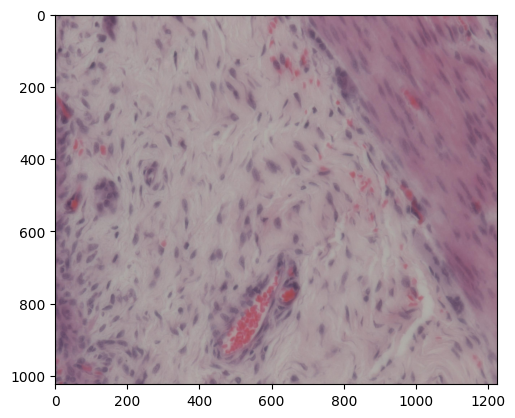

In [13]:
data_dir = "/n/data2/hms/dbmi/kyu/lab/maf4031/incoherent_RGBchannels/testRawData_incoherent_sameProtocol"
imgs = glob.glob(os.path.join(data_dir,'*/*.jpg'))
binned_img = bin_image(io.imread(imgs[0]), 2)

plt.imshow(binned_img)
plt.show()

In [3]:
def brenner_gradient(img: np.array) -> int:
        return np.sum((img[2:]-img[:-2])**2)

In [4]:
h, w = 720, 1280
patch_size = [360, 256]
x_steps = int(h / patch_size[0])
y_steps = int(w / patch_size[1])
x_coord = np.linspace(int(patch_size[0]/2), h - int(patch_size[0]/2), x_steps)
y_coord = np.linspace(int(patch_size[1]/2), w - int(patch_size[1]/2), y_steps)
patch_coords = [(x, y) for x in x_coord for y in y_coord]

In [5]:
def get_label_dict(sample_box: str, data_dir: str = "/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset", patch_coords: List = patch_coords, patch_size: List = [360, 256]) -> Dict:
    samples = glob.glob(os.path.join(data_dir, sample_box,'sample*'))
    sample_dict = {sample: {} for sample in samples}
    for sample in samples:
        images = glob.glob(os.path.join(sample,'*distance*.jpg'))
        image_dict = {patch: [0, 0, 0] for patch in range(len(patch_coords))}
        for image in images:
            img = io.imread(image)
            for patch_idx, (x, y) in enumerate(patch_coords):
                patch = img[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))]
                brenner_value = brenner_gradient(patch)
                if brenner_value > image_dict[patch_idx][-1]:
                    image_dict[patch_idx] = x, y, brenner_value
        sample_dict[sample] = image_dict
    return sample_dict


In [71]:
def get_label_samples_dict(sample: str, data_dir: str = "/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset", patch_coords: List = patch_coords, patch_size: List = [360, 256]) -> Dict:
    images = glob.glob(os.path.join(sample,'*distance*.jpg'))
    image_dict = {patch: [0, 0, 0] for patch in range(len(patch_coords))}
    for image in images:
        img = io.imread(image)
        for patch_idx, (x, y) in enumerate(patch_coords):
            patch = img[int(x-int(patch_size[0]/2)):int(x+int(patch_size[0]/2)), int(y-int(patch_size[1]/2)):int(y+int(patch_size[1]/2))]
            brenner_value = brenner_gradient(patch)
            if brenner_value > image_dict[patch_idx][-1]:
                img_idx = int(image.split('distance')[-1].split('.')[0])
                image_dict[patch_idx] = img_idx , brenner_value
    return {sample: image_dict}

In [86]:
data_dir = "/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset"
sample_boxes = next(os.walk(data_dir))[1]
samples = list(itertools.chain.from_iterable([glob.glob(os.path.join(data_dir, sample_box,'sample*')) for sample_box in sample_boxes]))
start = time.time()
with ProcessPoolExecutor(max_workers=61) as executor:
        futures = executor.map(
            get_label_samples_dict,
            samples,
        )
end = time.time()
print(end - start)
f = ChainMap(*dict(futures))

172.98817920684814


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [58]:
a = "/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_13/distance-539.jpg"
a.split("/")[-2]

'sample_13'

In [82]:

new_f = dict(ChainMap(*f))

In [85]:
new_f['/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_5/sample_1']

{0: (3, 4979103),
 1: (-3, 6188225),
 2: (-5, 12232614),
 3: (3, 13997881),
 4: (10, 4051406),
 5: (6, 6986118),
 6: (-3, 8302574),
 7: (-11, 5952315),
 8: (-1, 10458034),
 9: (12, 8535781)}

In [23]:
import torch

from patch_dataset import FocusDataset

In [24]:
dataset = torch.load("/home/maf4031/focus_model/data/test_patch_dataset.pt")

In [25]:
dataset.label_dict

{'Inflammation_3_4': {'/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_13': {0: 1760758,
   1: 4257502,
   2: 4614287,
   3: 1020184,
   4: 1547338,
   5: 1507739,
   6: 7319263,
   7: 11780154,
   8: 3492988,
   9: 2379728},
  '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_62': {0: 15601880,
   1: 20695909,
   2: 22807902,
   3: 20838763,
   4: 15558733,
   5: 17863837,
   6: 21145248,
   7: 21302495,
   8: 19286478,
   9: 15056769},
  '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_3': {0: 1692953,
   1: 3582010,
   2: 3552537,
   3: 6320795,
   4: 4048874,
   5: 1466343,
   6: 1634523,
   7: 5820465,
   8: 5918882,
   9: 4592091},
  '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflammation_3_4/sample_7': {0: 1798281,
   1: 1682947,
   2: 4512255,
   3: 869728,
   4: 1339381,
   5: 1576597,
   6: 6761006,
   7: 4208716,
   8: 768905,
   9: 2479194},
  '/n/data2/hms/dbmi/kyu/lab/maf4031/focus_dataset/Inflam

# Dataset Analysis

In [ ]:
import torch

In [1]:
train_dataset_dir = "/home/maf4031/focus_model/data/jiang_datasets/dataset_patch_train.pt"
test_dataset_dir = "/home/maf4031/focus_model/data/test/same_test_dataset.pt"